# Artificial Neural Networks and Deep Learning
# Homework 2: Image Segmentation

Students:

*   Julián Jiménez: 10657117
*   Samuel Polo: 10670388

## Transfer Learning Approach:

We first developed a simple test regarding the initial FCNN model and then proceeded to make some further improvements with preprocessing. After this, we decided to advance with the Transfer Learning approach, where we could use a successful pre-trained model in 2 ways: using fine tuning or using only the pre-trained weights.

We also decided to implement the U-net architecture as it was described in class that it had excellent performance on the image segmentation task and further expanded on the basic encoder-decoder model that we had implemented before.

For the contracting path we would use the downloaded model and we chose VGG19. Although it is not the best model in terms of accuracy or efficiency, we chose it as it is relatively simple with a low number of layers. This would allow us to go quickly through the model summary and pick out the outputs that we needed for the skip connections. Also the vgg19 model is very similar to the contracting path used in the u-net architecture so we believed that it would fit nicely within this architecture.

We implemented the expanding path utilizing transpose convolutions, swapping them with upsampling layers, concatenation layers which allowed for the skip connections, batch normalization and further convolutions. We initially chose the upsampling layers as they reduced the number of trainable parameters and improved training time, but transpose convolutions increased performance as these extra parameters allowed the model to learn a more effective way of performing the expanding path.

After successfully developing the U-net Model we proceeded to make an initial test with Transfer Learning, giving us a result of: 0.50850. Which improved in 119% our previous score with FCNN Model made from scratch.

Our first test was to use Transfer Learning without Fine Tuning, as this would improve the training time and give us an idea of the performance of the model, using the pre-trained VGG19 Model along with its pre-processing function that was added to both training and validation images. 

Finally we decided to use fine tuning as we had the idea that the imagenet dataset was trained for a large number of classes of images, while in this problem we are only trying to recognize buildings. Thus we found it useful for the model to learn the weights for contracting the image and specialize more for the specific problem at hand. This approach indeed created better results for the model.

Finally we experimented with other loss functions different to binary cross entropy, such as dice loss or a combination of the 2, but these led to lower performances.

We trained all models initially for 50 epochs without early stopping, monitoring the validation loss. If the model looked promising we would do more sets of 50 or 20 epochs of training until we saw no decrease in the validation loss. For the generation of results we would restore the model to the weights it had when it obtained the lowest validation loss.


Submited Tests, results without Fine Tuning:
*   Transfer Learning, vgg10, u-net model, 100 epochs : 0.52050
*   The previous model, 120 epochs: 0.52171

Submitted Tests with Fine Tuning:
*   Transfer Learning, vgg19, u-net model, 50 epochs: 0.58638
*   The previous model, 100 epochs: 0.61936
*   The previous model, 120 epochs: 0.62722
*   The previous model, 150 epochs: 0.47974
*   Transfer Learning, vgg19, u-net model, dice loss, 50 epochs: 0.53517

References:

* Ronneberger, Fischer, Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation - https://arxiv.org/pdf/1505.04597.pdf
* Simonyan, Zisserman. VGG19: VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION - https://arxiv.org/pdf/1409.1556.pdf
* Image segmentation tensorflow tutorial - https://www.tensorflow.org/tutorials/images/segmentation
* Nieradzik. Losses for Image Segmentation - https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [4]:
# Code to bring data from MyGoogleDrive to Python Notebook.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import os

In [6]:
# Set the seed for random operations. 
# This allows our process to be reproducible. 

SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()
print(cwd)

/content


In [0]:
# Set the directories for all, training and validation images.

dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')
training_dir = os.path.join(dataset_dir,'training')
valid_dir = os.path.join(dataset_dir,'validation')

# **Validation Directory Creation**

This code is used to create the validation directory and fill it up with images from all the classes. The validation set is created with stratified sampling since all classes are not represented equally in the given dataset. In this way from each class we select the same proportion of images. This is done to reduce sampling error and allow all classes to be represented in the validation set.

In [0]:
# Creates validation directory if it does not exist already.
_ = os.makedirs(valid_dir, exist_ok=True)

In [0]:
# Proportion for Hold-out set validation.
train_valid_split = 0.2

# Fills the validation set 
subfolders = [f.path for f in os.scandir(training_dir) if f.is_dir() ] 
flag = True
for subfold in subfolders:
  head_tail = os.path.split(subfold)
  _ = os.makedirs(os.path.join(valid_dir,head_tail[1],'img'), exist_ok=True)
  list_files = [name for name in os.scandir(os.path.join(subfold,'img')) if os.path.isfile(name)]
  num_files = len(list_files)
  if flag:
     rand = np.random.choice(num_files, int(num_files*train_valid_split) ,replace=False)
     flag = False
  for num in rand:
    file_name = os.path.split(list_files[num])
    os.rename(list_files[num],os.path.join(valid_dir,head_tail[1],'img',file_name[1]))

In [0]:
import json

dataset_split = {}
training_list = []
list_files = [name for name in os.scandir(os.path.join(training_dir,'images','img')) if os.path.isfile(name)]
for f in list_files:
  file_name = os.path.split(f)
  training_list.append(file_name[1])
valid_list = []
list_files = [name for name in os.scandir(os.path.join(valid_dir,'images','img')) if os.path.isfile(name)]
for f in list_files:
  file_name = os.path.split(f)
  valid_list.append(file_name[1])

dataset_split['training'] = training_list
dataset_split['validation'] = valid_list

with open('dataset_split.json', 'w') as fp:
     json.dump(dataset_split, fp)

# **Training and Validation Generators and Datasets**

In [0]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='reflect',
                                            rescale = 1./255,
                                            preprocessing_function=preprocess_input) 
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='reflect',
                                             rescale=1./255) 
# Use rescale=1./255 in the mask ImageDataGenerator to obtain binary values {0, 1} as target.
else:
    train_img_data_gen = ImageDataGenerator()
    train_mask_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale = 1./255,preprocessing_function=preprocess_input)
valid_mask_data_gen = ImageDataGenerator(rescale=1./255)

In [14]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')

# Batch size
bs = 24

# img shape
img_h = 256
img_w = 256

# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         color_mode = 'grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED)
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         color_mode='grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED)
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [0]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))

# We cast the masks to integer first to have 0,1 values
# Then back to float in order to manipulate them with functions that require float

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.int32)
    y_ = tf.cast(y_, tf.float32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)

# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()

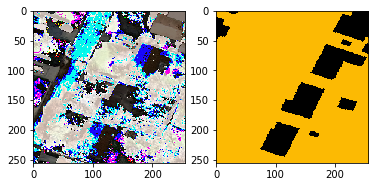

In [16]:
# Testing data generator
# -------------------------
import time
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(1, 2)
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [252, 186, 3]  # foreground
colors_dict[1] = [0, 0, 0]  # background

iterator = iter(train_dataset)

for _ in range(100):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]   # First element
    augmented_img = augmented_img * 255  # denormalize
    
    target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)
    
    # Assign colors for visualization
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(target_img))
    
    fig.canvas.draw()
    time.sleep(1)

# Model



## Transfer Learning

In [17]:
# Base Model
# -----------

img_h = 256
img_w = 256

#Downloading model: For this task we decided to use vgg19
#We do not include the fully connected layer

base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3),pooling='None')
base_model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [0]:
# Layers from which we are going to extract the output to use for the skip connections.
# The names are extracted from the above summary of the downloaded model

layer_names = [
    'block1_conv2',   # 256x256
    'block2_conv2',   # 128x128
    'block3_conv4',   # 64x64
    'block4_conv4',  # 32x32
    'block5_conv4',  # 16x16
    'block5_pool', #8x8
    ]
  
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Fine Tuning
down_stack.trainable = True

## U-Net Model

In [0]:
def unet_model(depth, start_f, num_classes, transpose):

  inputs = tf.keras.layers.Input(shape=[img_h, img_w, 3])
  ini = inputs

  # Contracting Path: vgg19 model
  skips = down_stack(ini)
  latent = skips[-1] # Last output of contracting path
  skips = skips[::-1] # Reverse outputs for use in expansive path

  # Further convolutions on last output to increase channels
  latent = tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         activation = 'relu')(latent)
  latent = tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         activation = 'relu')(latent)
                                        
  start_f = start_f//2

  # Expanding Path
  # 1. Transpose Convolution or Upsampling
  # 2. Concatenation
  # 3. Batch Normalization
  # 4. 2 Convolutions
  for i in range(1,depth):
    if transpose == True:
      up = tf.keras.layers.Conv2DTranspose(filters=start_f,
                                          kernel_size=(2, 2),
                                          strides=(2, 2),
                                          padding='same',
                                          activation = 'relu')(latent)
    if transpose == False:
      up = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(latent)
    up = tf.keras.layers.Concatenate()([up,skips[i]])
    up = tf.keras.layers.BatchNormalization()(up)
    latent = tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         activation = 'relu')(up)
    latent = tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         activation = 'relu')(latent)                                     
    if i != 1:
      start_f = start_f // 2

  # Final prediction layer, sigmoid activation function used
                                         
  prediction = tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid')(latent)

  return tf.keras.Model(inputs=inputs, outputs=prediction)

In [60]:
model = unet_model(depth=6, 
                     start_f=1024, 
                     num_classes=1,
                   transpose=True)

# Visualize created model as a table
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 256, 256, 64 20024384    input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 8, 8, 1024)   4719616     model[3][5]                      
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 8, 8, 1024)   9438208     conv2d_26[0][0]                  
____________________________________________________________________________________________

# Training

## **Intersection of Union (IoU) Metric for Validation**
We use the following metric to monitor the model performance while it is being trained.

In [0]:
def my_IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

## **Optimization Parameters**

In [0]:
# Optimization params
# -------------------

# Loss
# Binary Cross Entropy as we are using sigmoid activation for the final prediction layer
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Alternative loss function that is a combination of binary cross entropy and dice loss.
# Taken from: Nieradzik. Losses for Image Segmentation - https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
def custom_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2. * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1. - numerator / denominator, (-1, 1, 1))

    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------
metrics = [my_IoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## **Training with callbacks**

In [63]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

#Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True, save_best_only=True, mode='min')  # False to save the model directly
callbacks.append(ckpt_callback)


# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callbacks)


model_history = model.fit(x=train_dataset,
          epochs=50,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)


Train for 255 steps, validate for 64 steps
Epoch 1/20
255/255 [==============================] - 202s 790ms/step - loss: 0.2577 - my_IoU: 0.6977 - val_loss: 22.2748 - val_my_IoU: 0.7017
Epoch 2/20
255/255 [==============================] - 199s 781ms/step - loss: 0.2407 - my_IoU: 0.7172 - val_loss: 0.2451 - val_my_IoU: 0.7266
Epoch 3/20
255/255 [==============================] - 199s 781ms/step - loss: 0.2360 - my_IoU: 0.7234 - val_loss: 0.2411 - val_my_IoU: 0.7143
Epoch 4/20
255/255 [==============================] - 197s 772ms/step - loss: 0.2339 - my_IoU: 0.7221 - val_loss: 0.2499 - val_my_IoU: 0.7206
Epoch 5/20
255/255 [==============================] - 199s 779ms/step - loss: 0.2256 - my_IoU: 0.7312 - val_loss: 0.2329 - val_my_IoU: 0.7229
Epoch 6/20
255/255 [==============================] - 197s 772ms/step - loss: 0.2252 - my_IoU: 0.7327 - val_loss: 0.2666 - val_my_IoU: 0.6745
Epoch 7/20
255/255 [==============================] - 199s 782ms/step - loss: 0.2221 - my_IoU: 0.7388 - 

## Visualizing Training

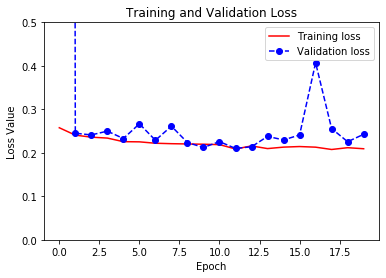

In [68]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(20)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

## Loading Best Weights

In [0]:
model.load_weights(os.path.join(
        cwd, 'segmentation_experiments', 'CNN_Dec14_11-54-06', 'ckpts', 'cp_10.ckpt'))

# **Testing Model**

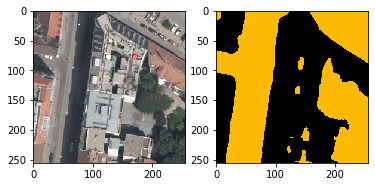

In [69]:
# Testing Image----------------------------------------------------------------------------
from PIL import Image
import time
import matplotlib.pyplot as plt

%matplotlib inline

test_dir = os.path.join(dataset_dir, 'test','images','img') #Path of our test images. 

img_filenames = next(os.walk(test_dir,'images','img'))[2] #Array of all test image files.
# Testing Zone--------------------------------------------------------------------------
fig, ax = plt.subplots(1, 2)
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [252, 186, 3]  # foreground
colors_dict[1] = [0, 0, 0]      # background

results = {}

img_filename = img_filenames[0]
    
img = Image.open(os.path.join(test_dir, img_filename))
img = img.resize((256, 256))    
img_arr = np.expand_dims(np.array(img), 0)
    

img_arr = preprocess_input(img_arr)
    
predicted_class = model.predict(x=img_arr / 255.)

predicted_class = tf.cast(predicted_class> 0.5, tf.float32)
predicted_class = predicted_class[0]


target = np.array(predicted_class)
target = np.squeeze(target, axis=-1)

    
# Assign colors for visualization
target_img = np.zeros([target.shape[0], target.shape[1], 3])  
target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]
ax[0].imshow(np.uint8(img))
ax[1].imshow(np.uint8(target_img))
    
fig.canvas.draw()

# Further Training of Model

## Saving Model

In [0]:
model.save('transfer_segmentation_fine_tuning.h5') 

## Loading Model

In [0]:
loaded_model = tf.keras.models.load_model('transfer_segmentation_fine_tuning2.h5',custom_objects={'my_IoU': my_IoU})
loaded_model.summary()

## Further Training

In [0]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

 #Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True, save_best_only=True, mode='min')  # False to save the model directly
callbacks.append(ckpt_callback)


# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callbacks)


loaded_ model_history= loaded_model.fit(x=train_dataset,
                                        epochs=20,  #### set repeat in training dataset
                                        steps_per_epoch=len(train_img_gen),
                                        validation_data=valid_dataset, 
                                        validation_steps=len(valid_img_gen), 
                                        callbacks=callbacks)

## Visualizing Training

In [0]:
loss = loaded_model_history.history['loss']
val_loss = loaded_model_history.history['val_loss']

epochs = range(20)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

## Loading Best Weights

In [0]:
loaded_model.load_weights(os.path.join(
        cwd, 'segmentation_experiments', 'CNN_Dec14_11-54-06', 'ckpts', 'cp_10.ckpt'))

# **Output of the Solution**

## **CSV Creation**

In [0]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

      f.write('ImageId,EncodedPixels,Width,Height\n')

      for key, value in results.items():
          f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')

##**Encode Prediction Masks**

In [0]:
from PIL import Image
import time

def rle_encode(img): #Input img is the predicted mask with 0 and 1 values.
      # Flatten column-wise
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)


test_dir = os.path.join(dataset_dir, 'test','images','img') #Path of our test images. 

image_filenames = next(os.walk(test_dir))[2] #Array of all test image files.

results = {}
for img_filename in image_filenames:
    
    mask_filename = img_filename[:-4]
    
    img = Image.open(os.path.join(test_dir, img_filename))
    img = img.resize((256, 256))
    
    img_arr = np.expand_dims(np.array(img), 0)

    img_arr = preprocess_input(img_arr)
    
    predicted_class = model.predict(x=img_arr / 255.)

    predicted_class = tf.cast(predicted_class> 0.5, tf.float32)
    predicted_class = predicted_class[0]

    target = np.array(predicted_class)
    results[mask_filename] = rle_encode(target)

create_csv(results)